I./ Pré traitement  

1) Packages utilisés

In [51]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time

from multiprocessing import cpu_count    
from joblib import Parallel   # Pour la parallélisation
from joblib import delayed


2) Importation des donnéés

In [52]:
df = pd.read_excel(r"/Users/marcimhof/Documents/bit_coin/bit_coin_price.xlsx")
data = df["change_in_doll"]
print(len(data))
data.head()

73


0     83.38
1    140.10
2    -69.00
3    -35.68
4     42.24
Name: change_in_doll, dtype: float64

3) Transformation en série temporelle

Ici on se place dans le cadre de série temporelle donc on va chercher à prevoir chaque Yt en fonction d'un nombre définit de Xt (Xt-n,...,Xt)

In [53]:
def make_time_serie(data, n_step_in, n_step_out):
    X, Y = list(), list()
    for i in range(len(data)):
        end_patt = i + n_step_in
        out_end = end_patt + n_step_out
        if out_end > len(data):
            break
        seq_X, seq_Y  = data[i:end_patt], data[end_patt:out_end] 
        X.append(seq_X)
        Y.append(seq_Y)
    return np.array(X), np.array(Y)

X, Y = make_time_serie(data, n_step_in = 4, n_step_out = 1)
example = [1,2,3,4,5,6,7,8,9]
make_time_serie(example,3,1)

(array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8]]),
 array([[4],
        [5],
        [6],
        [7],
        [8],
        [9]]))

II./ Création du modèle

1) Fonctions utiles 

On retrouve ici les fonctions pour normaliser, plutot standardiser ici.
On standardise Y avec la même métrique que X pour garder la cohérence.

In [54]:
def standardise(X, Y):
    mean = np.mean(X)
    std = np.std(X)
    X = (X - mean) / std
    Y = (Y - mean) / std
    return X, Y, mean, std

def reverse_standardise(X, mean, std): 
    X = np.dot(X,std) + mean
    return X

On retrouve ici les fonction d'activations des couches cachés et de sorties

In [55]:
def relu(z, derivative = False):
    if derivative :
        return np.where(z <= 0, 0, 1)
    return np.where(z <= 0, 0, z)

def prelu(z, alpha = 0.5, derivative = False): 
    if derivative :
        return np.where(z <= 0, alpha, 1)
    return np.where(z <= 0, alpha*z, z)

def linear(z, alpha = 0.5, derivative = False): 
    if derivative :
        return alpha * np.ones(len(z))
    return alpha * z

def identity(z, derivative = False):
    if derivative:
        return (1)
    return z

Les fonctions loss pour minimiser l'erreur des prédictions

In [56]:
def log_cosh_loss(w1, w2, h2, y, n_step_in, periode):
    return np.log(np.cosh(y[periode] - h2)).sum()

def loss_MSE(w1, w2, h2, y, n_step_in, periode):
    return (np.square(y[periode] - h2).sum()) / len(y[periode])

2) Création du modèle

In [57]:
""" Initialisation """
def init(X, output_dim, hidden_dim, input_dim):
    np.random.seed(222)
    w1 = np.random.randn(input_dim, hidden_dim)
    w2 = np.random.randn(hidden_dim, output_dim)
    w1 = w1 / np.sqrt(input_dim)   # On divise par la racine de la dimension pour homogénéiser
    w2 = w2 / np.sqrt(hidden_dim)
    return w1, w2

""" La partie forward du modèle """

""" On divise en plusieurs cas en fonction des fonctions d'activations """
def modele(X, weights, periode, hidden_layer, output_layer,coeff_prelu , coeff_linear):
    if hidden_layer == "relu":
        h1 = relu(np.matmul(X[periode], weights[0]))
        if output_layer == "linear":
            h2 = linear(np.matmul(h1, weights[1]), coeff_linear) # Coeff correspond au f(x) = ax
        elif output_layer == "identity":
            h2 = identity(np.matmul(h1, weights[1]))
    elif hidden_layer == "prelu":
        h1 = prelu(np.matmul(X[periode], weights[0]), coeff_prelu)
        if output_layer == "linear":
            h2 = linear(np.matmul(h1, weights[1]), coeff_linear)
        elif output_layer == "identity":
            h2 = identity(np.matmul(h1, weights[1]))
    return h1, h2

""" On calcule les gradients des poids qu'on cherche à minimiser """
def gradient(w1, w2, h1, h2, X, Y, periode, loss_func, hidd_activation, output_activation, coeff_prelu, coeff_linear):
    dz2_dw2 = h1.reshape(h1.shape[0],1) # on doit reshape pour pouvoir faire du calcul matricielle 
    dz2_dh1 = w2
    
    if loss_func == "MSE":
        dL_dh2 = -2 * (Y[periode] - h2)
        if output_activation == "linear":
            dh2_dz2 = linear(np.matmul(h1, w2), coeff_linear, derivative = True)
            if hidd_activation == "prelu":
                dh1_dz1 = prelu(np.matmul(X[periode], w1), coeff_prelu, derivative = True)
            elif hidd_activation == "relu":
                dh1_dz1 = relu(np.matmul(X[periode], w1), derivative = True)
        elif output_activation == "identity":
            dh2_dz2 = identity(np.matmul(h1, w2), derivative = True)
            if hidd_activation == "prelu":
                dh1_dz1 = prelu(np.matmul(X[periode], w1), coeff_prelu, derivative = True)
            elif hidd_activation == "relu":
                dh1_dz1 = relu(np.matmul(X[periode], w1), derivative = True)
                
    if loss_func == "log_cosh_loss":
        dL_dh2 = - np.tanh(Y[periode] - h2)
        if output_activation == "linear":
            dh2_dz2 = linear(np.matmul(h1, w2), coeff_linear, derivative = True)
            if hidd_activation == "prelu":
                dh1_dz1 = prelu(np.matmul(X[periode], w1), coeff_prelu, derivative = True)
            elif hidd_activation == "relu":
                dh1_dz1 = relu(np.matmul(X[periode], w1), derivative = True)
        elif output_activation == "identity":
            dh2_dz2 = identity(np.matmul(h1, w2), derivative = True)
            if hidd_activation == "prelu":
                dh1_dz1 = prelu(np.matmul(X[periode], w1), coeff_prelu, derivative = True)
            elif hidd_activation == "relu":
                dh1_dz1 = relu(np.matmul(X[periode], w1), derivative = True)
    
    A = dL_dh2 * dh2_dz2
    A = A.reshape(1, A.shape[0])
    dL_dw2 = np.matmul(dz2_dw2, A)
    
    dL_dz2 = dL_dh2 * dh2_dz2 
    dL_dh1 = np.matmul(dL_dz2, (dz2_dh1.T))
    dz1_dw1 = X[periode].reshape(X[periode].shape[0],1)
    A = dL_dh1 * dh1_dz1
    A = A.reshape(1, A.shape[0])
    dL_dw1 = np.matmul(dz1_dw1, A)
    
    return dL_dw1, dL_dw2

""" On soustrait l'erreur (descente de gradient)"""
def update(w1, w2, dL_dw1, dL_dw2, learning_rate):
    w1 = w1 - (learning_rate*dL_dw1)
    w2 = w2 - (learning_rate*dL_dw2)
    return w1, w2

""" Prediction pour une période (un certain nombre de Xt données)"""
def predict(X, w1, w2, periode, hidden_layer, output_layer, coeff_prelu , coeff_linear):
    h1, h2 = modele(X, [w1,w2], periode, hidden_layer, output_layer, coeff_prelu , coeff_linear)
    return h2

In [58]:
""" On implémente le forward et le backward, autrement dit on implémente toutes les fonctions dans cette fonction """
def MLP_Regressor(X, Y, learning_rate, n_iter, N, layer_hidden_dim,
                 n_step_in, n_step_out, loss_func, hidd_activation,
                 output_activation, alpha, beta):
    
    w1, w2 = init(X, output_dim = n_step_out, hidden_dim = layer_hidden_dim, input_dim = n_step_in)
    Loss = []  # On crée une liste pour avoir l'erreur à chaque itération dans la descente de gradient
    y_pred = []
    for j in range(N): # Pour parcourir la série temporelle
        for i in range(n_iter): # Nombre d'itération pour la descente de gradient
            h1, h2 = modele(X, [w1, w2], j, hidden_layer = hidd_activation, output_layer = output_activation, 
                            coeff_prelu = alpha, coeff_linear = beta)
            if loss_func == "MSE":
                Loss.append(loss_MSE(w1, w2, h2, Y, n_step_in, j))
            elif loss_func == "log_cosh_loss": 
                Loss.append(log_cosh_loss(w1, w2, h2, Y, n_step_in, j))
            dL_dw1, dL_dw2 = gradient(w1, w2, h1, h2, X, Y, j, loss_func, hidd_activation, 
                                      output_activation, coeff_prelu = alpha, coeff_linear = beta)
            w1, w2 = update(w1, w2, dL_dw1, dL_dw2, learning_rate)  # On met à jour les poids avec les gradients
        y_pred.append(predict(X, w1, w2, j, hidden_layer = hidd_activation, 
                              output_layer = output_activation, coeff_prelu = alpha, coeff_linear = beta))
        # On stock dans y_pred les prédictions d'entrainement 
    
    return y_pred, w1, w2, dL_dw1, dL_dw2, h1, h2


III./ Walk forward validation

Comme nous sommes dans le cadre d'une série temporelle on ne peut pas parler de cross validation car les Xt ne sont pas indépendants. Chaque Xt dépend de ses valeurs précendentes.

On ne peut donc pas prendre plusieurs échantillons avec un ordre aléatoire.

Une méthode possible est la walk forward validation.

In [59]:
""" On va créer une liste contenant toutes les possibilités des paramètres à configurer"""

def parametre(data):
    loss_param = ["MSE", "log_cosh_loss"]
    hidd_acti_param = ["prelu", "relu"]
    output_acti_param = ["identity", "linear"]
    iter_param = [100, 200, 500]
    learning_param = [0.01, 0.001]
    hidd_dim_param = [5, 10, 15]
    alpha_param = [0.1, 0.5, 1.5]
    beta_param = [0.1, 0.5, 1.5]
    model = list()
    for loss_i in loss_param : 
        for hidd_dim_i in hidd_dim_param:
            for output_acti_i in output_acti_param:
                for iter_i in iter_param : 
                    for learning_i in learning_param:
                        for hidd_acti_i in hidd_acti_param:
                            for alpha_i in alpha_param:
                                for beta_i in beta_param:
                                    config = [learning_i, 1, iter_i, hidd_dim_i, loss_i, hidd_acti_i, output_acti_i,
                                             alpha_i, beta_i]
                                    model.append(config)
    return model



Parallélisation pour optimiser les performances. 

Si l'on veut tester de nombreux paramètres, la charge de calcul peut devenir conséquente.
Ainsi en améliorant les performances on économise beaucoup de temps. 

In [60]:
""" Création de la fonction qui va scorer une configuration de paramètre afin de les classer ultérieurement """
def score(data, cfg, start_size, n_step_out):
    size = 0
    min_size = start_size
    n_step_out_i = n_step_out
    test = []
    reel = []
    for n_step_in_i in range(min_size, len(data) - n_step_out_i):
        X, Y = make_time_serie(data, n_step_in = n_step_in_i, n_step_out = n_step_out_i)
        X, Y, mu, sigma = standardise(X,Y)
        y_pred, w1, w2, dL_dw1, dL_dw2, h1, h2 = MLP_Regressor(X, Y, learning_rate = cfg[0], n_iter = cfg[2], N = cfg[1], 
                                                               layer_hidden_dim = cfg[3],
                                                               n_step_in = n_step_in_i, n_step_out = n_step_out_i, 
                                                               loss_func = cfg[4], hidd_activation = cfg[5], 
                                                               output_activation = cfg[6], 
                                                               alpha = cfg[7], beta = cfg[8])
        
        temp = predict(X, w1, w2, size, hidden_layer = cfg[5], output_layer = cfg[6], 
                       coeff_prelu = cfg[7], coeff_linear = cfg[8])
        temp = reverse_standardise(temp, mu, sigma)
        Y = reverse_standardise(Y, mu, sigma)
        test.append(temp)
        reel.append(Y[size])
    MSE = np.abs(np.array(reel) - np.array(test)).sum() / len(test)
    
    key = cfg
    return MSE, key

""" Création de la validation en parallélisant les calculs """
def walking_forward_validation(data, start_size, n_step_out):
    model = parametre(data)
    score_MSE = Parallel(n_jobs = cpu_count())(delayed(score)(data, cfg, start_size, n_step_out) for cfg in model)
    score_MSE.sort(key=lambda tup:tup[0], reverse = False) # Trie la liste des scores par la plus petite MSE 
    return score_MSE

IV/ Test et performances du modèles

Il est temps de visualiser les performances du modèles après paramétrage.

On peut évaluer les performances sur plusieurs métriques en gardant à l'idée leur signification.

Pour ce faire on va séparer la série en 2 échantillons train et test (garder à l'esprit que l'on ne pas séparer aléatoirement)

Pour le train, le modèle apprendra avec la descente de gradient.

On évalue la performance sur le test dont on connait la valeur.
Le modèle ne pourra plus se perfectionner sur le test, les poids resteront inchangés.

In [61]:
""" On lance le modèle avec les meilleurs paramaètres trouvés"""

def MLP_Regressor_opti(data, start_size, n_step_in, n_step_out, len_test):
    test, index = [], []
    n_step_in_i = n_step_in
    n_step_out_i = n_step_out
    best_param = walking_forward_validation(data, start_size , n_step_out = n_step_out_i)[0][1]
    X, Y = make_time_serie(data, n_step_in = n_step_in_i, n_step_out = n_step_out_i)
    X, Y, mu, sigma = standardise(X,Y)
    train_size = len(X) - len_test
    y_pred, w1, w2, dL_dw1, dL_dw2, h1, h2 = MLP_Regressor(X, Y, learning_rate = best_param[0], n_iter = best_param[2], N = train_size, 
                                                           layer_hidden_dim = best_param[3],
                                                           n_step_in = n_step_in_i, n_step_out = n_step_out_i, 
                                                           loss_func = best_param[4], hidd_activation = best_param[5], 
                                                           output_activation = best_param[6], 
                                                           alpha = best_param[7], beta = best_param[8])
    for i in range(train_size - 1, len(X)):
        test.append(predict(X, w1, w2, periode = i, hidden_layer = best_param[5], output_layer = best_param[6],
                            coeff_prelu = best_param[7], coeff_linear = best_param[8]))
        index.append(i)
    test = reverse_standardise(test, mu, sigma)
    y_pred = reverse_standardise(y_pred, mu, sigma)
    Y = reverse_standardise(Y, mu, sigma)

    MSE = np.square(np.array(Y[index]) - np.array(test)).sum() / (len(test))
    return MSE, test, y_pred, Y, index, best_param

start_time = time.time()

MSE, test, y_pred, Y, index, best_param = MLP_Regressor_opti(data, start_size = 40, n_step_in = 2, n_step_out = 1, len_test = 8)
print('MSE : ', MSE)
print('')
print(' Best paramètres  : ',best_param)
end_time = time.time()

print("temp d'exécution : ", round(end_time - start_time,3)/60, "min")

/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/3440856341.py:5: RuntimeWarning: overflow encountered in square
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:25: RuntimeWarning: overflow encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:25: RuntimeWarning: invalid value encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:42: RuntimeWarning: overflow encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:42: RuntimeWarning: invalid value encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/3440856341.py:5: RuntimeWarning: overflow encountered in square
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:25: RuntimeWarning: overflow encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:25:

/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:23: RuntimeWarning: overflow encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:23: RuntimeWarning: invalid value encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:36: RuntimeWarning: overflow encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:36: RuntimeWarning: invalid value encountered in matmul
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/3440856341.py:5: RuntimeWarning: overflow encountered in square
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:78: RuntimeWarning: invalid value encountered in subtract
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/2815503978.py:79: RuntimeWarning: invalid value encountered in subtract
/var/folders/5t/cfgqcsys329cs7f34xvndj700000gn/T/ipykernel_47299/28

MSE :  153095873.00444758

 Best paramètres  :  [0.01, 1, 200, 5, 'MSE', 'prelu', 'identity', 0.5, 1.5]
temp d'exécution :  7.016883333333333 min


On peut visualiser à l'aide d'un plot

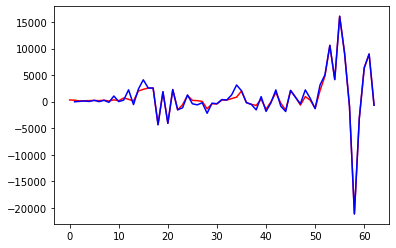

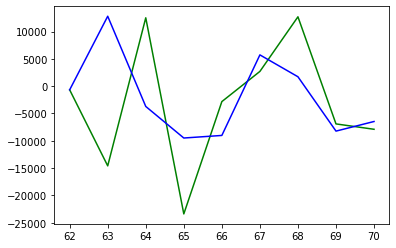

In [62]:
index_train = np.arange(1,len(y_pred))
plt.plot(y_pred, color='red')
plt.plot(index_train,Y[index_train], color='blue')
plt.show()

plt.plot(index, test, color='green')
plt.plot(index, Y[index], color = 'blue')
plt.show()